The Classification for several selected band sets from four algorithms are calculated here. 

In [2]:
import pandas as pd
import time
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.io import loadmat
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [3]:
KSC = Path(r'C:\Datasets\KennedySpaceCenter\KSC.mat')
KSCGt = Path(r'C:\Datasets\KennedySpaceCenter\KSC_gt.mat')

def read_KSC():
    KSC_X = loadmat(KSC)['KSC']
    KSC_Y = loadmat(KSCGt)['KSC_gt']
    return KSC_X, KSC_Y 

In [4]:
def bands_separation(bands, datasetX, datasetY):
    
    #Read data
    data_X = datasetX
    data_Y = datasetY
    
    data_X_selected = data_X[:,:,bands]

    print(data_X_selected.shape)

    #data dimensions
    x, y, z = data_X_selected.shape

    #reshapes arrays to have all data of each matrix into vectors
    data_X2d = data_X_selected.reshape((x * y, z))
    data_Y2d = data_Y.reshape((x * y, 1))

In [5]:
def extract_pixels(X, y):
    q = X.reshape(-1, X.shape[2])
    df = pd.DataFrame(data = q)
    df = pd.concat([df, pd.DataFrame(data = y.ravel())], axis=1)
    df.columns= [f'band{i}' for i in range(1, 1+X.shape[2])]+['class']
    #df.to_csv('Dataset.csv')
    return df

In [6]:
#Reading data from HBS algorithms
def HBS_bands():
    bands_FDPC = loadmat('SelectedBandsOCF_KSC.mat')['band_FDPC']

    #bands_NC_IE = loadmat('SelectedBandsOCF.mat')['band_NC_IE']

    bands_simil = loadmat('SelectedSBS_KSC.mat')['bands_simil']

    bands_svd = loadmat('SelectedSBS_KSC.mat')['bands_svd']

    #bands_EGCSR = np.load("bands_EGCSR.npy").astype(int) + 1
    
    bands_bombs = np.load("bands_bombs_KSC.npy").astype(int)

    #nonzeroind = np.nonzero(bands_svd)[0] # the return is a little funny so I use the [0]
    #print(nonzeroind)


    bands = {
        "FDPC" : bands_FDPC,
        #"NC_IR" : bands_NC_IE,
        "simil" : bands_simil,
        "svd" : bands_svd,
        #"EGCSR" : bands_EGCSR,
        "bombs": bands_bombs
    }
    
    return bands
    
'''
for k in bands:        
    x,y = bands[k].shape
    
    for i in range(x):
        
        print(k, "selection for: ", (i+1)*5," bands is: ", bands[k][i,:(i+1)*5],"\n")
'''

'\nfor k in bands:        \n    x,y = bands[k].shape\n    \n    for i in range(x):\n        \n        print(k, "selection for: ", (i+1)*5," bands is: ", bands[k][i,:(i+1)*5],"\n")\n'

In [48]:
#MAIN 

#Reads selected number of bands for different algorithms into a dictionary
bands = HBS_bands()

HBS_predictions = {}

HBS_accuracy = {}

HBS_class_accuracy = {}

HBS_class_maps = {}

iterations = 10
factor = 5

#name of classes for Kennedy space center
names = ['Scrub','Willow-swamp', 'CP hammock','CP/Oak','Slash Pine','Oak/Broadleaf',
'Hardwood swamp','Graminoid marsh','Spartina marsh','Catiail marsh','Salt marsh',
'Mod flats', 'Water'] 
    
#Iterates over bands sets 
for k in bands:        
    x,y = bands[k].shape
    
    for i in range(x):
        
        b_count = (i+1)*factor
        
        #reads indian dataset
        dataset_X,dataset_Y = read_KSC()
        #takes selected bands from indian dataset
        dataset_X_selected = dataset_X[:,:,bands[k][i,:b_count]-1]

        #print for confirmation
        print("Processing: ", k, b_count)

        #data dimensions
        x, y, b = dataset_X_selected.shape
        
        ####data to pandas dataframe
        dataframe = extract_pixels(dataset_X_selected, dataset_Y)

        #cleaning data
        data_x = dataframe[dataframe['class'] != 0]
        dataframe_X2d = data_x.iloc[:, :-1].values
        dataframe_Y2d = data_x.loc[:, 'class'].values 

        # Split dataset into training set and test set
        X_train, X_test, y_train, y_test = train_test_split(dataframe_X2d, dataframe_Y2d,
                                                            test_size=0.9, random_state=11, stratify=dataframe_Y2d)
        
        #Creates Svm Clasiffier
        indian_classifier = svm.SVC(C = 120, kernel = 'poly', degree = 2, cache_size = 10*1024)

        #Train the model using the training sets
        indian_classifier.fit(X_train, y_train.ravel())

        #Prediction of test set using trained model
        HBS_predictions[str(k) + "_pred_" + str(b_count)] = indian_classifier.predict(X_test)   
        
        l=[]
        for i in range(dataframe.shape[0]):
            #this if statement ignore class 0 for the classification. Coloring it black in image.
            l.append(indian_classifier.predict(dataframe.iloc[i, :-1].values.reshape(1, -1)))

        HBS_class_maps[str(k) + "_pred_" + str(b_count)] = np.array(l).reshape(x, y).astype('int')


    for n in HBS_predictions:        

        accuracy = metrics.accuracy_score(y_test, HBS_predictions[n])
        
        HBS_accuracy[str(k) + "_acc_" + str(b_count)] = accuracy

        class_accuracy = metrics.confusion_matrix(y_test, HBS_predictions[n], normalize="true").diagonal()

        HBS_class_accuracy[str(k) + "_acc_" + str(b_count)] = class_accuracy
   

Processing:  FDPC 5
Processing:  FDPC 10
Processing:  FDPC 15
Processing:  FDPC 20
Processing:  FDPC 25


In [ ]:
#Saving Classification results
np.save("KSC_Class_maps", HBS_class_maps)
np.save("KSC_predictions", HBS_predictions)
np.save("KSC_accuracy", HBS_accuracy)
np.save("KSC_class_acc", HBS_class_accuracy)

In [7]:
#Loads Classification results if available
HBS_predictions = np.load('KSC_predictions.npy', allow_pickle=True).item()
HBS_accuracy = np.load('KSC_accuracy.npy', allow_pickle=True).item()
HBS_class_accuracy = np.load('KSC_class_acc.npy', allow_pickle=True).item()
HBS_class_maps = np.load('KSC_Class_maps.npy', allow_pickle=True).item()

In [29]:
###Classification results

for a in HBS_accuracy:     
    
    print(a, " accuracy is " ,HBS_accuracy[a])

FDPC_acc_5  accuracy is  0.8473347547974414
FDPC_acc_10  accuracy is  0.8752665245202559
FDPC_acc_15  accuracy is  0.9
FDPC_acc_20  accuracy is  0.8985074626865671
FDPC_acc_25  accuracy is  0.9031982942430704
FDPC_acc_30  accuracy is  0.9038379530916845
FDPC_acc_35  accuracy is  0.9046908315565032
FDPC_acc_40  accuracy is  0.9031982942430704
FDPC_acc_45  accuracy is  0.9
FDPC_acc_50  accuracy is  0.9004264392324094
simil_acc_5  accuracy is  0.1791044776119403
simil_acc_10  accuracy is  0.17825159914712155
simil_acc_15  accuracy is  0.17825159914712155
simil_acc_20  accuracy is  0.17846481876332623
simil_acc_25  accuracy is  0.1788912579957356
simil_acc_30  accuracy is  0.17867803837953092
simil_acc_35  accuracy is  0.17867803837953092
simil_acc_40  accuracy is  0.17825159914712155
simil_acc_45  accuracy is  0.18038379530916845
simil_acc_50  accuracy is  0.20277185501066097
svd_acc_5  accuracy is  0.17867803837953092
svd_acc_10  accuracy is  0.17846481876332623
svd_acc_15  accuracy is  

In [40]:
for a in HBS_accuracy:     
    cont = 0
    classnum = 1
    if a[-2] == "1" and a[-1] == "0":
        for c in names:

            print(a, " class\t" , classnum , " accuracy is: \t" , HBS_class_accuracy[a][cont])
            
            classnum += 1
            cont += 1 



FDPC_acc_10  class	 1  accuracy is: 	 0.948905109489051
FDPC_acc_10  class	 2  accuracy is: 	 0.954337899543379
FDPC_acc_10  class	 3  accuracy is: 	 0.9260869565217391
FDPC_acc_10  class	 4  accuracy is: 	 0.5594713656387665
FDPC_acc_10  class	 5  accuracy is: 	 0.38620689655172413
FDPC_acc_10  class	 6  accuracy is: 	 0.5825242718446602
FDPC_acc_10  class	 7  accuracy is: 	 0.5851063829787234
FDPC_acc_10  class	 8  accuracy is: 	 0.7938144329896907
FDPC_acc_10  class	 9  accuracy is: 	 0.8910256410256411
FDPC_acc_10  class	 10  accuracy is: 	 0.9587912087912088
FDPC_acc_10  class	 11  accuracy is: 	 0.9416445623342176
FDPC_acc_10  class	 12  accuracy is: 	 0.9116997792494481
FDPC_acc_10  class	 13  accuracy is: 	 0.9988009592326139
simil_acc_10  class	 1  accuracy is: 	 0.0
simil_acc_10  class	 2  accuracy is: 	 0.0
simil_acc_10  class	 3  accuracy is: 	 0.0
simil_acc_10  class	 4  accuracy is: 	 0.0
simil_acc_10  class	 5  accuracy is: 	 0.0
simil_acc_10  class	 6  accuracy is: 	 0.

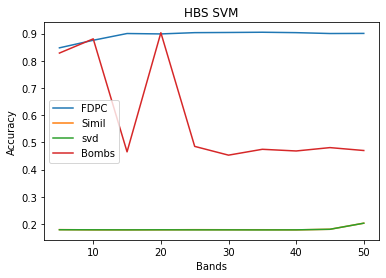

In [18]:
x = np.array([5,10,15,20,25,30,35,40,45,50])

a = np.zeros(iterations)
#b = np.zeros(iterations)
c = np.zeros(iterations)
d = np.zeros(iterations)
#e = np.zeros(iterations)
f = np.zeros(iterations)

for i in range(iterations):
    
    b_count = (i+1)*factor
    
    a[i] = HBS_accuracy["FDPC_acc_" + str(b_count)]
    #b[i] = HBS_accuracy["NC_IR_acc_" + str(b_count)]
    c[i] = HBS_accuracy["simil_acc_" + str(b_count)]
    d[i] = HBS_accuracy["svd_acc_" + str(b_count)]
    #e[i] = HBS_accuracy["EGCSR_acc_" + str(b_count)]
    f[i] = HBS_accuracy["bombs_acc_" + str(b_count)]
    
    
plt.plot(x, a, label='FDPC')  
#plt.plot(x, b, label='NC IR')  
plt.plot(x, c, label='Simil')
plt.plot(x, d, label='svd') 
#plt.plot(x, e, label='EGCSR') 
plt.plot(x, f, label='Bombs')

plt.xlabel('Bands')
plt.ylabel('Accuracy')
plt.title("HBS SVM")
plt.legend()

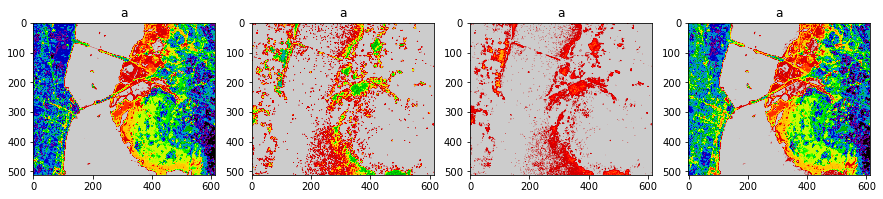

In [8]:
#Plotting classification map for all the algorithms with 10 bands
cont = 0
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 4))
for a in HBS_class_maps:    
     
    if a[-2] == "1" and a[-1] == "0":

        im = axes[cont].imshow(HBS_class_maps[a], cmap='nipy_spectral')
        tx = axes[cont].set_title("a")
        axes[cont].grid(False)
        cont +=1